In [1]:
# Import necessary libraries
import os
import cv2 as cv
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from mtcnn import MTCNN  # MTCNN for face detection


In [2]:
# Directory where dataset is stored
DIR = r'data\train'  # Update this path with your dataset's location
people = ['rohan']  # List of people for training


In [3]:
# Initialize MTCNN face detector
detector = MTCNN()


In [4]:
# Features and labels initialization
features = []
labels = []

# Function to create training data
def create_training_data():
    for person in people:
        path = os.path.join(DIR, person)
        label = people.index(person)

        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            img_array = cv.imread(img_path)
            img_rgb = cv.cvtColor(img_array, cv.COLOR_BGR2RGB)  # Convert to RGB
            
            # Detect faces using MTCNN
            faces = detector.detect_faces(img_rgb)

            for face in faces:
                x, y, w, h = face['box']
                face_roi = img_rgb[y:y + h, x:x + w]
                resized_face = cv.resize(face_roi, (224, 224))  # Resize for MobileNetV2 input
                resized_face = np.array(resized_face)  # Ensure the resized image is an array
                features.append(resized_face)
                labels.append(label)

# Call function to create training data
create_training_data()


In [6]:
# Convert to numpy arrays
features = np.array(features, dtype='float32') / 255.0  # Normalize pixel values
labels = np.array(labels)

# Ensure features have the shape (224, 224, 3)
print(f'Initial Features shape: {features.shape}')  # Print initial features shape

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(people))
y_val = to_categorical(y_val, num_classes=len(people))

# Ensure the shapes of training and validation data
print(f'Training data shape: {X_train.shape}')  # Print training data shape
print(f'Validation data shape: {X_val.shape}')  # Print validation data shape


Initial Features shape: (35, 224, 224, 3)
Training data shape: (28, 224, 224, 3)
Validation data shape: (7, 224, 224, 3)


In [7]:
# Load MobileNetV2 base model (pre-trained on ImageNet)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the transfer learning model on top of MobileNetV2
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(people), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the transfer learning model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32
)

# Save the trained transfer learning model
model.save('face_recognition_mobileNetV2.h5')
print("Transfer learning model training complete and saved.")


Epoch 1/15


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step - accuracy: 1.0000 - loss: 0.0000e+0

Transfer learning model training complete and saved.


In [9]:
# Load the trained model
model = load_model('face_recognition_mobileNetV2.h5')

# Initialize webcam (for local setup)
cap = cv.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not access the webcam.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame from the webcam. Exiting...")
        break

    img_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)  # Convert to RGB

    # Detect faces using MTCNN
    faces = detector.detect_faces(img_rgb)

    for face in faces:
        x, y, w, h = face['box']
        face_roi = img_rgb[y:y + h, x:x + w]
        resized_face = cv.resize(face_roi, (224, 224))
        normalized_face = resized_face / 255.0
        reshaped_face = normalized_face.reshape(1, 224, 224, 3)  # 3 channels for RGB

        # Predict using the transfer learning model
        predictions = model.predict(reshaped_face)
        confidence = np.max(predictions) * 100

        if confidence < 50:
            label_text = f'Unknown Person ({confidence:.2f}%)'
        else:
            label = np.argmax(predictions)
            label_text = f'{people[label]} ({confidence:.2f}%)'

        # Display label and confidence on the video feed
        cv.putText(frame, label_text, (x, y - 10), cv.FONT_HERSHEY_COMPLEX, 0.7, (0, 255, 0), 2)
        cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the real-time video feed (use normal OpenCV window in Visual Studio)
    cv.imshow("Webcam - Face Recognition", frame)

    # Exit the webcam feed when 'q' is pressed
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv.destroyAllWindows()


Failed to grab frame from the webcam. Exiting...


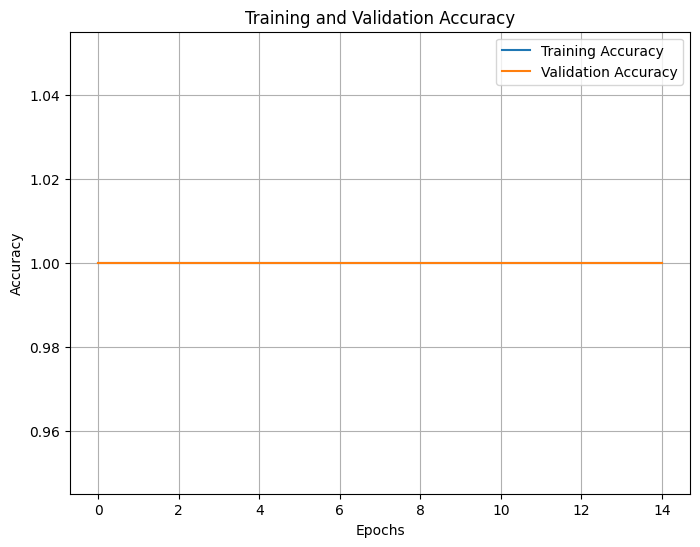

In [8]:
import matplotlib.pyplot as plt

# Get training and validation accuracy from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
